Title: "Forecasting Bitcoin Prices with Time Series Analysis"

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.api import tsa

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Correct way to import datetime
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg

In [4]:

#Loading the data
data = pd.read_csv('data/bitcoin_USD_close_data-2017-02-09_2018-02-09.csv',
                   parse_dates=['Date'])
print(data.shape)
data.tail()

(366, 2)


,Date,Price
361,2018-02-05,6914.26
362,2018-02-06,7700.39
363,2018-02-07,7581.80
364,2018-02-08,8237.24
365,2018-02-09,8689.84


In [5]:

data['Date'] = data['Date'].dt.date
data.set_index(pd.to_datetime(data['Date']), inplace=True)
data.drop('Date', axis=1, inplace=True)
data.head()

,Price
Date,
2017-02-09,988.95
2017-02-10,993.08
2017-02-11,1010.00
2017-02-12,999.51
2017-02-13,996.86


<Axes: xlabel='Date'>

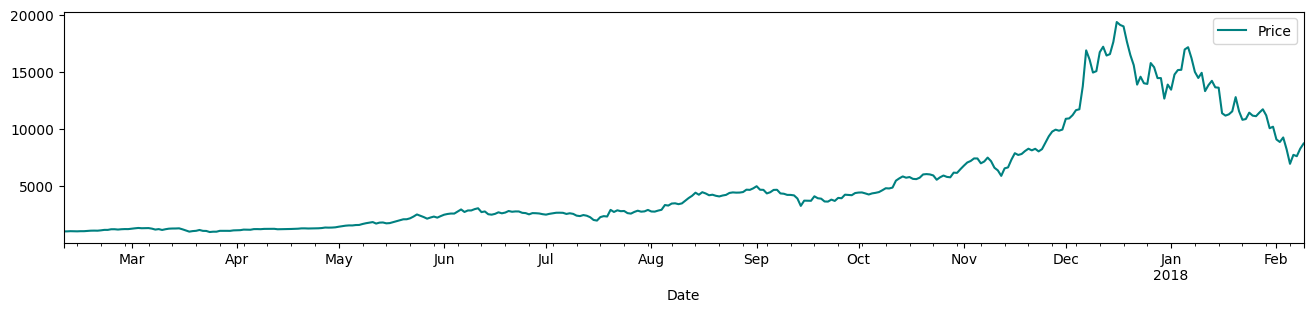

In [6]:
data.plot(y='Price', color='teal', figsize=(16,3))

C:\Users\elsie\AppData\Local\Temp\ipykernel_19028\4192170077.py:1: FutureWarning: The provided callable <function mean at 0x00000230474D7880> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  price_weekly_avg = data.resample('W').apply(np.mean)
C:\Users\elsie\AppData\Local\Temp\ipykernel_19028\4192170077.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_monthly_avg = data.resample('M').apply(np.mean)
C:\Users\elsie\AppData\Local\Temp\ipykernel_19028\4192170077.py:2: FutureWarning: The provided callable <function mean at 0x00000230474D7880> is currently using DatetimeIndexResampler.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  price_monthly_avg = data.resample('M').apply(np.mean)


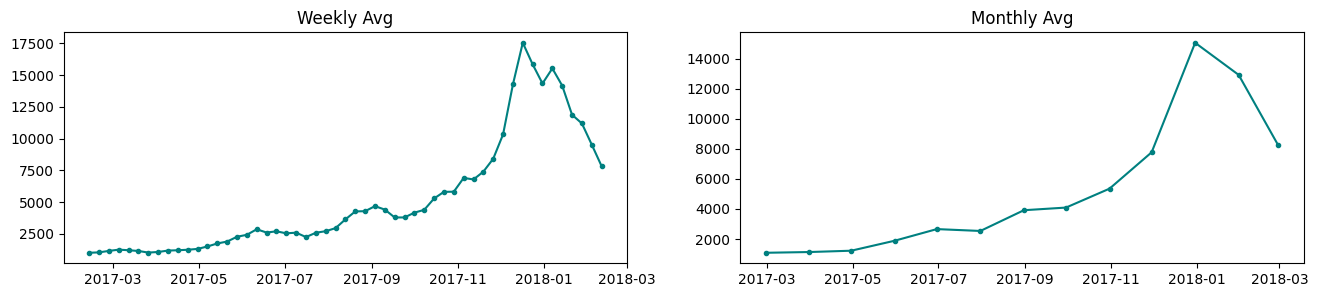

In [7]:

price_weekly_avg = data.resample('W').apply(np.mean)
price_monthly_avg = data.resample('M').apply(np.mean)
plt.figure(figsize=(16,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.Price, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.Price, "-o", markersize=3, color='teal')

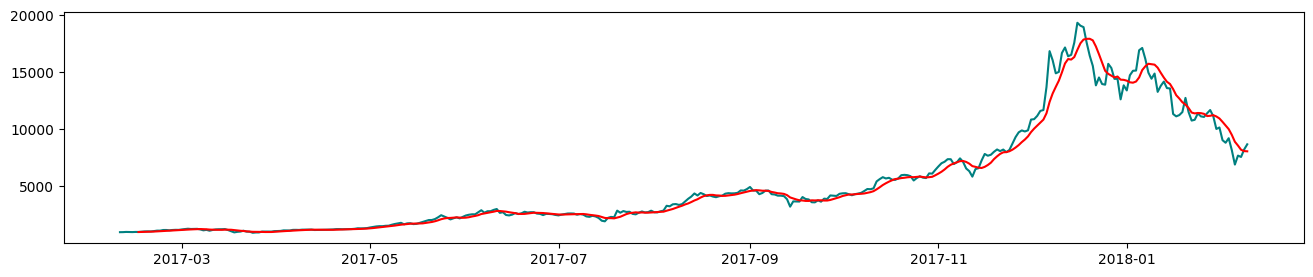

In [8]:
rolling_mean = data.Price.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better 
plt.figure(figsize=(16,3))
plt.plot(data.Price, color='teal')
plt.plot(rolling_mean, 'red')

Text(0, 0.5, 'Autocorrelation')

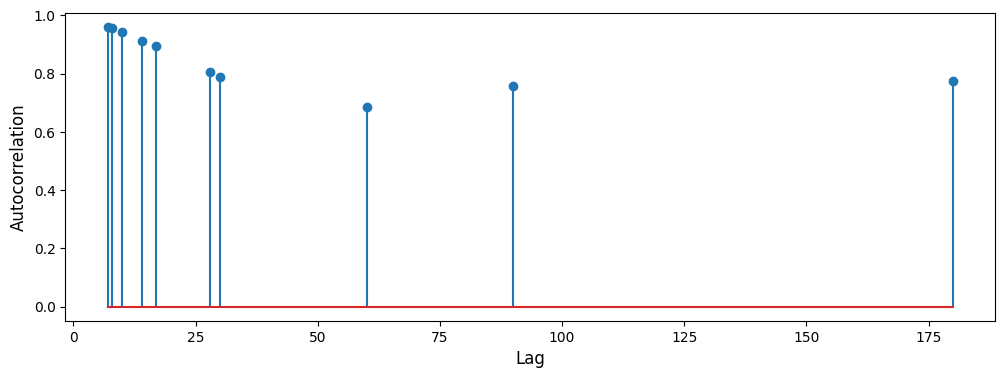

In [9]:
lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180] 
autocorrs = [data.Price.autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

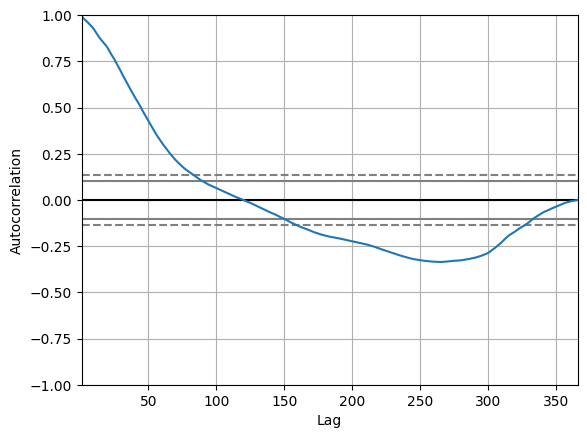

In [10]:
from pandas.plotting import autocorrelation_plot

# Assuming 'data' is your DataFrame or Series
autocorrelation_plot(data)

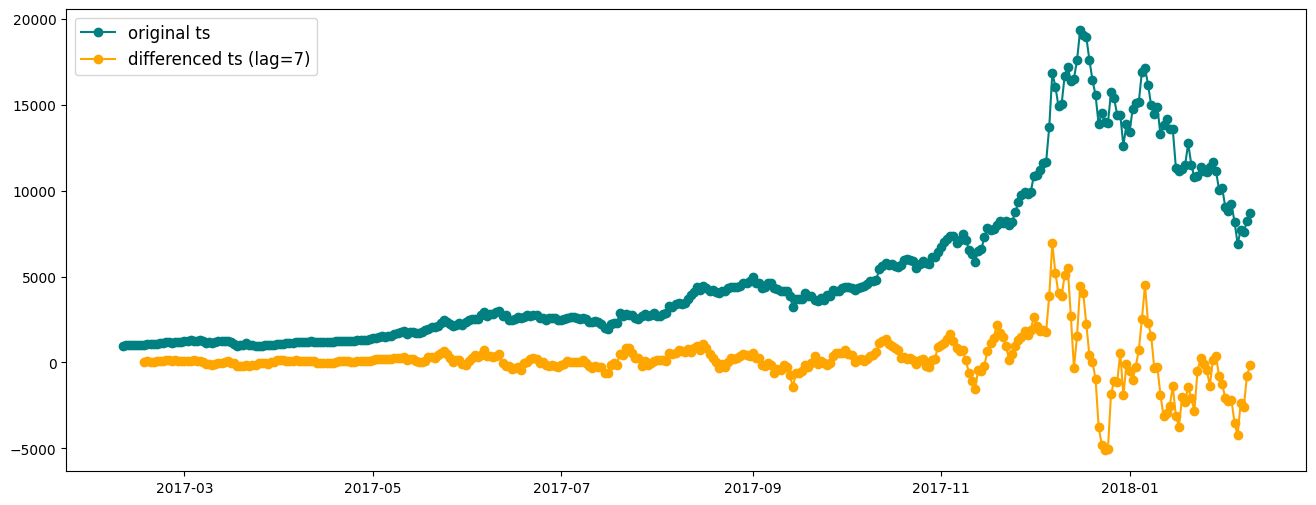

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(data.Price, '-o', color='teal', label="original ts")
plt.plot(data.Price.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)

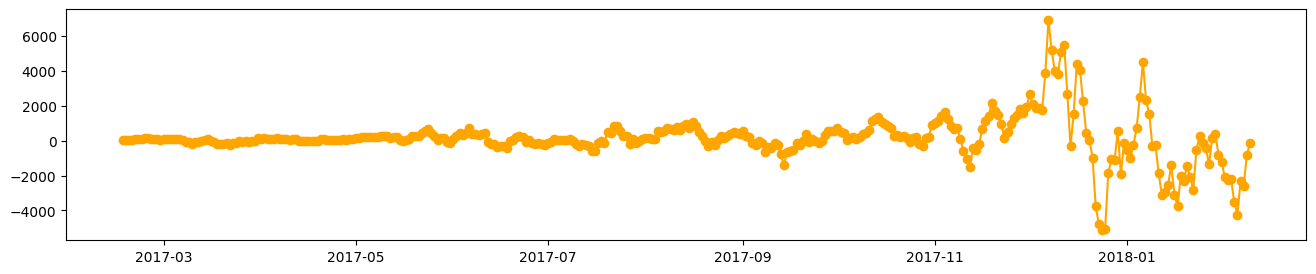

In [12]:
prices = data.Price
price_diff = prices.diff(7).dropna() 

plt.figure(figsize=(16,3))
plt.plot(price_diff, "-o", color='orange')

In [13]:
time_series = price_diff

In [14]:
def organize_data(to_forecast, window, horizon=1):
    
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

lag = 90
X, y = organize_data(time_series.to_numpy(), lag)

MAE = 241.978
MAE2 = 335.892


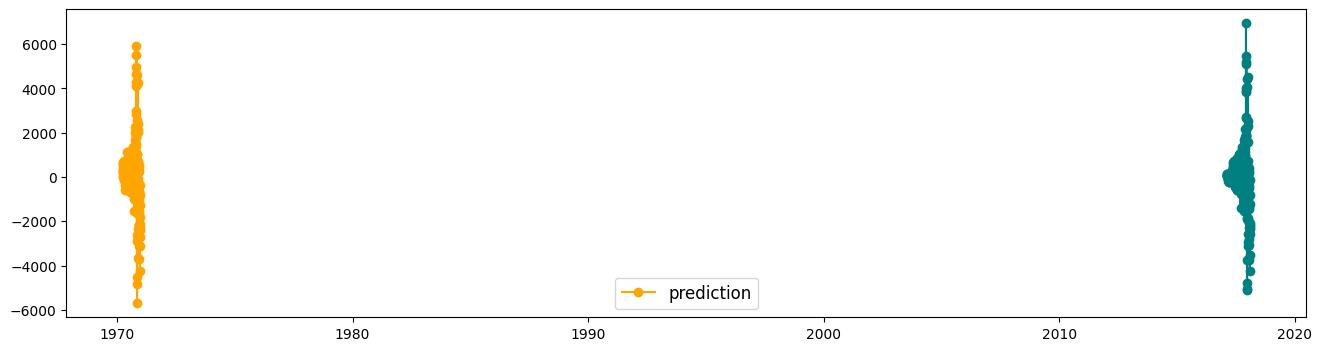

In [15]:
lr = LinearRegression()
lr_fit = lr.fit(X, y)
lr_prediction = lr_fit.predict(X)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', color='teal')  # Removed.values
plt.plot(np.arange(lag, len(time_series)), lr_prediction, '-o', label='prediction', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], lr_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], lr_prediction[-90:]))) #for the last 90 days only

In [16]:
ar = AutoReg(time_series, lags=91)
results = ar.fit()

print("Best optimal lag for ar model: {}".format(results.model.k_ar))

C:\Users\elsie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AttributeError: 'AutoReg' object has no attribute 'k_ar'

In [ ]:

lag = 47 
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag, ic='aic')
ar_prediction = ar_fit.predict(start=lag)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(ar_prediction, '-o', label='model', color='orange')
plt.legend(fontsize=12);

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[lag:], ar_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], ar_prediction[-90:])))

In [ ]:

arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q for lag and moving average 
arma_fit = arma.fit()
start=100
arma_prediction = arma_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arma_prediction, '-o', label='model', color='orange')
plt.legend();
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arma_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], arma_prediction[-90:])))

In [ ]:
#7 out of sample prediction with AR 
lag = 47
ar = tsa.AR(time_series)
ar_fit = ar.fit(maxlag=lag)
ar_forecast = ar_fit.predict(end=len(time_series)+6)[-7:] 
ar_forecast

In [ ]:
arma = tsa.ARMA(time_series, order=(7, 7)) 
arma = arma.fit()
arma_forecast = arma.predict(end=len(time_series)+6)[-7:]
arma_forecast

In [ ]:
#and here ARIMA which is basically same thing as ARMA but in a slightly different implementation.
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
arima_forecast= arima_fit.forecast(steps=7)[0]
arima_forecast

In [ ]:
#AR model's 7 out of sample predictions
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(ar_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [ ]:
#ARMA model's 7 out sample predicitons 
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arma_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [ ]:
print(prices[-7:]) #the actual last 7 sample prices

In [ ]:
idx = ar_forecast.index.values

forecast_prices = []
lag = 7
for i, diff in enumerate(ar_forecast): #choosing AR as it produced lower MAE than ARMA model
    prev_value = prices[-(lag)+i:][0]
    forecast_prices.append(prev_value+diff)
    
bitcoin_forecast = pd.Series(forecast_prices, index=idx)
bitcoin_forecast

In [ ]:
hist_values = data['Price'].append(bitcoin_forecast)

plt.figure(figsize=(16,4))
plt.plot(hist_values, '-o', color='teal', alpha=0.5)
plt.show

In [ ]:
real_price = pd.DataFrame(data={"price":[8556.61, 8070.8, 8891.21, 8516.24, 9477.84, 10016.49, 10178.71],
                          "dates":['2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13', '2018-02-14', '2018-02-15',
                               '2018-02-16']})

real_price.set_index(pd.to_datetime(real_price['dates']), inplace=True)
real_price.drop('dates', axis=1, inplace=True)
real_price

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(real_price, "-o", color="teal", label="real price")
plt.plot(bitcoin_forecast, "-o", color="orange", label="predicted")
plt.legend(fontsize=12)
plt.show()